In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-square/eiffel-tower-2JRVWG1-600.jpg
/kaggle/input/time-square/png-transparent-times-square-broadway-calabasas-jigsaw-puzzles-shanghai-times-square-display-advertising-city-united-states-thumbnail.png
/kaggle/input/mountain/lovepik-green-mountains-under-blue-sky-and-white-clouds-png-image_401563651_wh1200.png
/kaggle/input/beared-men/0957e91386efc8e60a622fbbc2171a93.jpg
/kaggle/input/tower-bridge/tower bridge.png


In [92]:
!pip install diffusers==0.3.0 --q
!pip install transformers scipy ftfy --q
!pip install "ipywidgets>=7,<8" --q
import IPython.display 

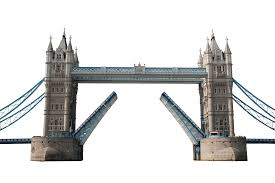

In [93]:
IPython.display.Image("/kaggle/input/tower-bridge/tower bridge.png")

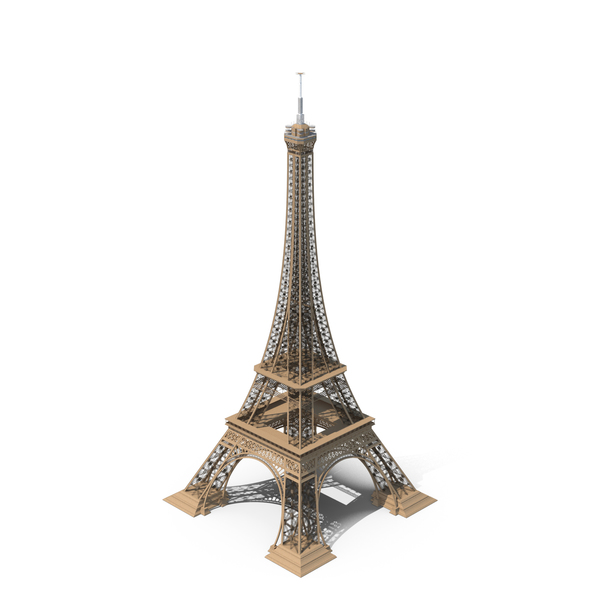

In [94]:
IPython.display.Image("/kaggle/input/time-square/eiffel-tower-2JRVWG1-600.jpg")

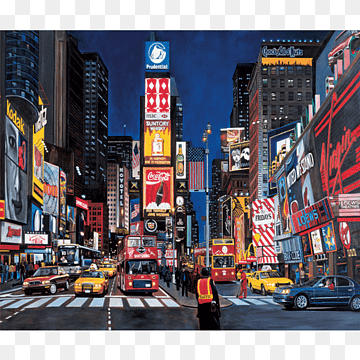

In [95]:
IPython.display.Image("/kaggle/input/time-square/png-transparent-times-square-broadway-calabasas-jigsaw-puzzles-shanghai-times-square-display-advertising-city-united-states-thumbnail.png")

# 1. Import the Libraries

In [96]:
import gc
import torch
from PIL import Image
import IPython.display 
from torch import autocast
from tqdm.auto import tqdm
from kaggle_secrets import UserSecretsClient
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler , PNDMScheduler


user_secrets = UserSecretsClient()
Hugging_face  = user_secrets.get_secret("Stable Diffusion")

# 2. Hyperparameters

In [97]:
class config : 
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    HEIGHT = 512                        
    WIDTH = 512                         
    NUM_INFERENCE_STEPS = 500            
    GUIDANCE_SCALE = 7.5                
    GENERATOR = torch.manual_seed(48)   
    BATCH_SIZE = 1

# 3. Helper Functions

In [98]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# 4. Pipeline
**4.1 Loading the pretrained Models**

In [99]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=Hugging_face)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=Hugging_face)
vae = vae.to(config.DEVICE)
text_encoder = text_encoder.to(config.DEVICE)
unet = unet.to(config.DEVICE) 


In [100]:
print(f'\033[94mTokenizer, Text Encoder, VAE, Unet are loaded !!')

Tokenizer, Text Encoder, VAE, Unet are loaded !!


**4.2 Scheduler**

In [101]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
print(f'\033[94mThe scheduler loaded is K-LMS Sceheduler')

The scheduler loaded is K-LMS Sceheduler


**4.3 First Image**

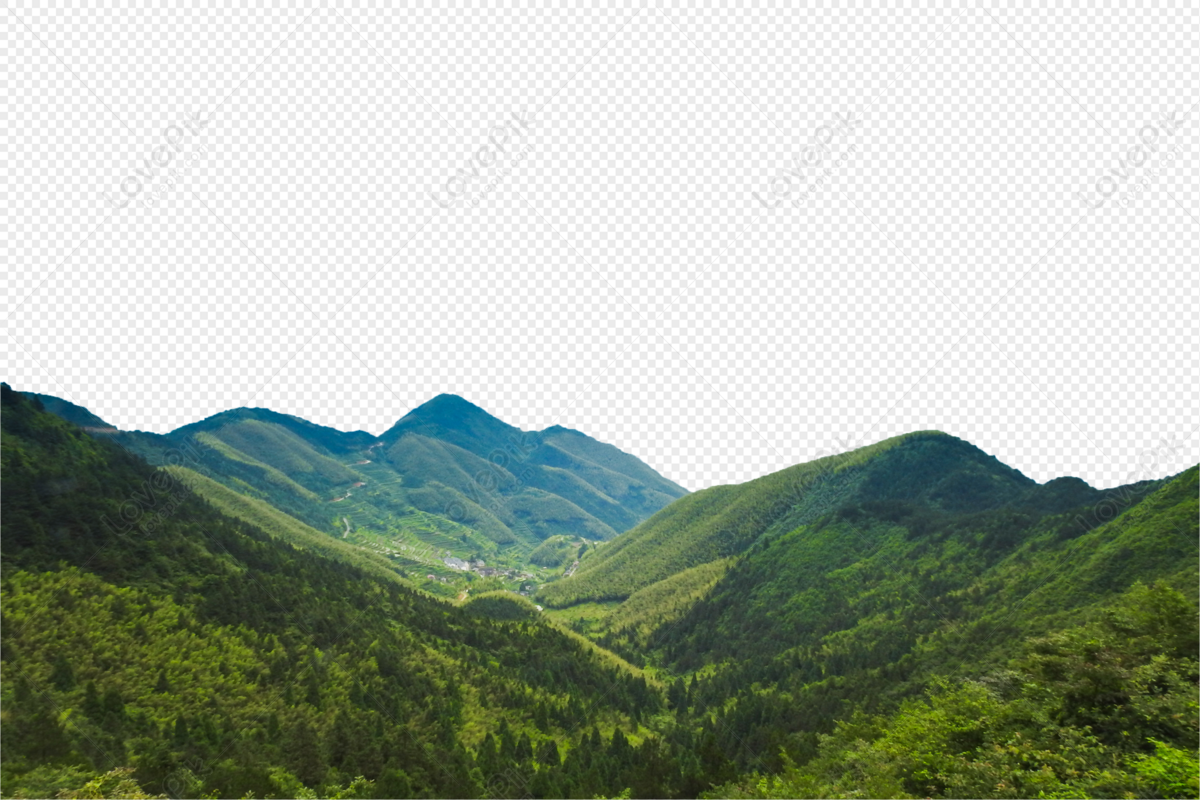

In [102]:
IPython.display.Image("/kaggle/input/mountain/lovepik-green-mountains-under-blue-sky-and-white-clouds-png-image_401563651_wh1200.png")

In [103]:
prompt = ["A realistic image of men that wear white shirt and wear black glasses on the face "]

In [104]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
max_length = text_input.input_ids.shape[-1]
with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(config.DEVICE))[0]
uncond_input = tokenizer(
    [""] * config.BATCH_SIZE, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(config.DEVICE))[0]   
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(f'\033[94mText Embeddings shape: {text_embeddings.shape}')

Text Embeddings shape: torch.Size([2, 77, 768])


In [105]:
latents = torch.randn(
  (config.BATCH_SIZE, unet.in_channels, config.HEIGHT // 8, config.WIDTH // 8),
  generator=config.GENERATOR,
)
latents = latents.to(config.DEVICE)

print(f'\033[94mLatent shape: {latents.shape}')

Latent shape: torch.Size([1, 4, 64, 64])


**4.3.1 Encoding the Image**

In [106]:
scheduler.set_timesteps(config.NUM_INFERENCE_STEPS)
latents = latents * scheduler.sigmas[0]

In [107]:
with autocast(config.DEVICE):
      for i, t in tqdm(enumerate(scheduler.timesteps)):
        
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        with torch.no_grad():
              noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + config.GUIDANCE_SCALE * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, i, latents).prev_sample

0it [00:00, ?it/s]

**4.3.2 Decoding the image**

In [108]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample
print(f'\033[94mImage shape: {image.shape}')

Image shape: torch.Size([1, 3, 512, 512])


**4.3.3 Visualize the Image**

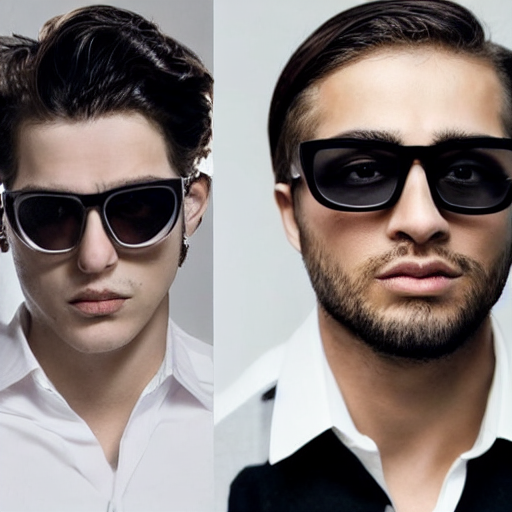

In [109]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

# 4.4 Second Image 

.Tokenising the prompt

.Text embeddings

.Latent intialization


The text we are going to visualize is :

Make a image of long beard man who weared the dark blue gense pants and wear white shirt and also wear the blue round shape glasses on the face.  

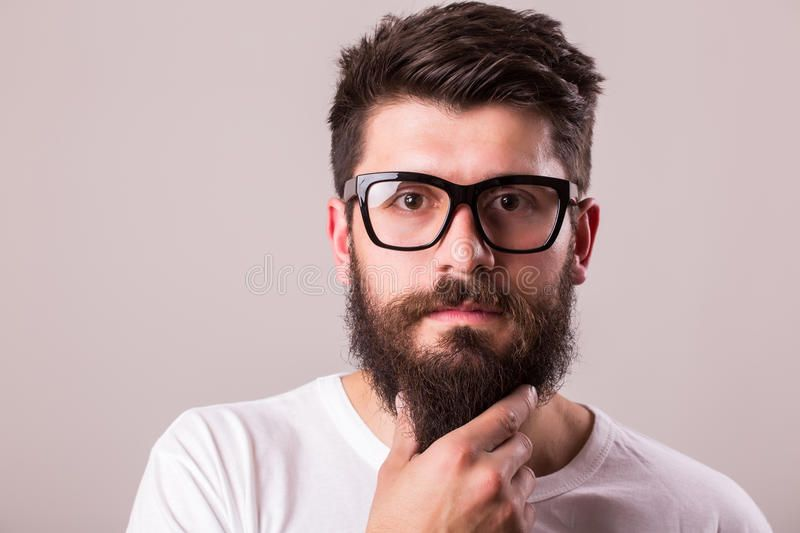

In [110]:
IPython.display.Image("/kaggle/input/beared-men/0957e91386efc8e60a622fbbc2171a93.jpg")


In [111]:
prompt = ["A hyperrealistic photo of a sleek black sports car, parked on a wet city street at night, neon lights reflecting on the chrome."]

In [112]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
max_length = text_input.input_ids.shape[-1]
with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(config.DEVICE))[0]
uncond_input = tokenizer(
    [""] * config.BATCH_SIZE, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(config.DEVICE))[0]   
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(f'\033[94mText Embeddings shape: {text_embeddings.shape}')

Text Embeddings shape: torch.Size([2, 77, 768])


In [113]:
latents = torch.randn(
  (config.BATCH_SIZE, unet.in_channels, config.HEIGHT // 8, config.WIDTH // 8),
  generator=config.GENERATOR,
)
latents = latents.to(config.DEVICE)

print(f'\033[94mLatent shape: {latents.shape}')

Latent shape: torch.Size([1, 4, 64, 64])


**4.4.1 Encoding the image**

In [114]:
scheduler.set_timesteps(config.NUM_INFERENCE_STEPS)
latents = latents * scheduler.sigmas[0]

In [115]:
with autocast(config.DEVICE):
      for i, t in tqdm(enumerate(scheduler.timesteps)):
        
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        with torch.no_grad():
              noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + config.GUIDANCE_SCALE * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, i, latents).prev_sample

0it [00:00, ?it/s]

**4.4.2 Decoding the image**


In [116]:
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample
print(f'\033[94mImage shape: {image.shape}')

Image shape: torch.Size([1, 3, 512, 512])


**4.4.3 Visualizing the image**


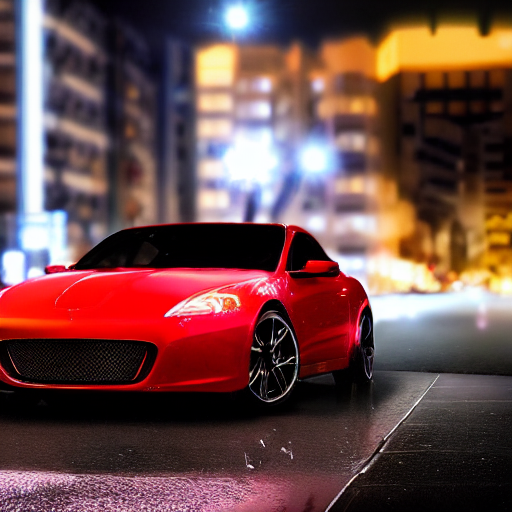

In [117]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0].save("img2.jpg")
pil_images[0]


In [118]:
del latents
del vae
del text_encoder
del unet
gc.collect()

68